In [1]:
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = Path('/work/rodrigues_2023/')

#### Import metadata and extracted barcode read counts (output of the 30-find-barcodes.py)

In [2]:
meta = pd.read_csv(PROJECT_PATH / 'data/reference/marinelle-mouse-samples-metadata.txt', sep='\t', index_col=0)
meta

,untreated_mouse1,untreated_mouse2,untreated_mouse3,untreated_mouse4,untreated_mouse5,untreated_mouse6,cefepime_treated_mouse_7,cefepime_treated_mouse_8,cefepime_treated_mouse_9,cefepime_treated_mouse_10,cefepime_treated_mouse_11,cefepime_treated_mouse_12
Days,,,,,,,,,,,,
0,C1R_D0,C1L_D0,C1N_D0,C2R_D0,C2RL_D0,C2N_D0,C3L_D0,C3N_D0,C3R_D0,C4L_D0,C4N_D0,C4R_D0
1,C1R_D1,C1L_D1,C1N_D1,C2R_D1,C2RL_D1,C2N_D1,C3L_D1,C3N_D1,C3R_D1,C4L_D1,C4N_D1,C4R_D1
2,C1R_D2,C1L_D2,C1N_D2,C2R_D2,C2RL_D2,C2N_D2,C3L_D2,C3N_D2,C3R_D2,C4L_D2,C4N_D2,C4R_D2
3,C1R_D3,C1L_D3,C1N_D3,C2R_D3,C2RL_D3,C2N_D3,C3L_D3,C3N_D3,C3R_D3,C4L_D3,C4N_D3,C4R_D3
4,C1R_D4,C1L_D4,C1N_D4,C2R_D4,C2RL_D4,C2N_D4,C3L_D4,C3N_D4,C3R_D4,C4L_D4,C4N_D4,C4R_D4
5,C1R_D5,C1L_D5,C1N_D5,C2R_D5,C2RL_D5,C2N_D5,C3L_D5,C3N_D5,C3R_D5,C4L_D5,C4N_D5,C4R_D5
6,C1R_D6,C1L_D6,C1N_D6,C2R_D6,C2RL_D6,C2N_D6,C3L_D6,C3N_D6,C3R_D6,C4L_D6,C4N_D6,C4R_D6
7,C1R_D7,C1L_D7,C1N_D7,C2R_D7,C2RL_D7,C2N_D7,C3L_D7,C3N_D7,C3R_D7,C4L_D7,C4N_D7,C4R_D7


In [3]:
counts_dir = PROJECT_PATH / "dump/bgi/barcode-counts"
trajectories={}
for sample in meta.columns:
    days = [pd.read_csv(counts_dir / (meta.loc[day, sample]+'.counts'), sep='\t', names=['barcode', day]) for day in meta.index]
    sample_df = days[0]
    for day in days[1:]:
        sample_df = sample_df.merge(day, on='barcode', how='outer')
    sample_df.fillna(0, inplace=True)
    trajectories[sample] = sample_df

In [4]:
trajectories.keys()

dict_keys(['untreated_mouse1', 'untreated_mouse2', 'untreated_mouse3', 'untreated_mouse4', 'untreated_mouse5', 'untreated_mouse6', 'cefepime_treated_mouse_7', 'cefepime_treated_mouse_8', 'cefepime_treated_mouse_9', 'cefepime_treated_mouse_10', 'cefepime_treated_mouse_11', 'cefepime_treated_mouse_12'])

In [5]:
trajectories['untreated_mouse5'].head(3)

,barcode,0,1,2,3,4,5,6,7
0,AAGGTGACAGT,4886.0,10377.0,3798.0,23380.0,15397.0,7397.0,5889.0,1324.0
1,ACCGCTACACA,4769.0,997.0,131.0,446.0,1076.0,956.0,95.0,683.0
2,AAGGTGACAGA,4253.0,9229.0,3908.0,21087.0,15837.0,6088.0,5712.0,1297.0


#### Normalize reads by the total barcoded read count at each sample

In [6]:
traj_norm = deepcopy(trajectories)
traj_cov = []
for sample in traj_norm.keys():
    for day in traj_norm[sample].columns[1:]:
        sample_total_read_count_with_barcodes = sum(trajectories[sample][day])
        traj_cov.append({'sample':sample, 'day':day, 'coverage':sample_total_read_count_with_barcodes})
        traj_norm[sample][day] = traj_norm[sample][day].apply(lambda x: x/sample_total_read_count_with_barcodes)
traj_cov = pd.DataFrame(traj_cov)

In [7]:
traj_norm['untreated_mouse1']

,barcode,0,1,2,3,4,5,6,7
0,AAGGTGACAGT,0.236558,0.270031,0.228342,0.259865,0.268385,0.133828,0.176646,0.239962
1,AAGGTGACAGA,0.192559,0.228083,0.212408,0.233461,0.270384,0.126577,0.152091,0.202090
2,AAGGTGACAGC,0.083960,0.095126,0.078038,0.087308,0.092246,0.047986,0.062588,0.084090
3,AGGGTAGCCTA,0.054083,0.005891,0.004152,0.005639,0.004044,0.001309,0.003375,0.014763
4,AACGACCCATA,0.044432,0.016225,0.012495,0.007185,0.027860,0.004615,0.003106,0.068345
...,...,...,...,...,...,...,...,...,...
2167,AACGACCCAGG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
2168,ATGGCCACCTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
2169,AAAGCTACTGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035
2170,ATCGTGGCANT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035


In [8]:
for sample in traj_norm.keys():
    traj_norm[sample].to_csv(f'{sample}_all_barcodes_sorted.csv', index=False)

#### Plot trajectories of the most frequent barcodes over time

In [9]:
def get_freq_plot_table(traj_norm, sample_name='untreated_mouse1', top=100):
    traj_plot = []
    selected_sample = traj_norm[sample_name]
    ssum = selected_sample.sum(axis=1).sort_values(ascending=False)
    for row in selected_sample.loc[ssum.index,:].iloc[:top,:].iterrows():
        for day in selected_sample.columns[1:]:
            traj_plot.append({'barcode': row[1]['barcode'], 
                            'day': int(day),
                            'freq': row[1][day]})
    return pd.DataFrame(traj_plot)

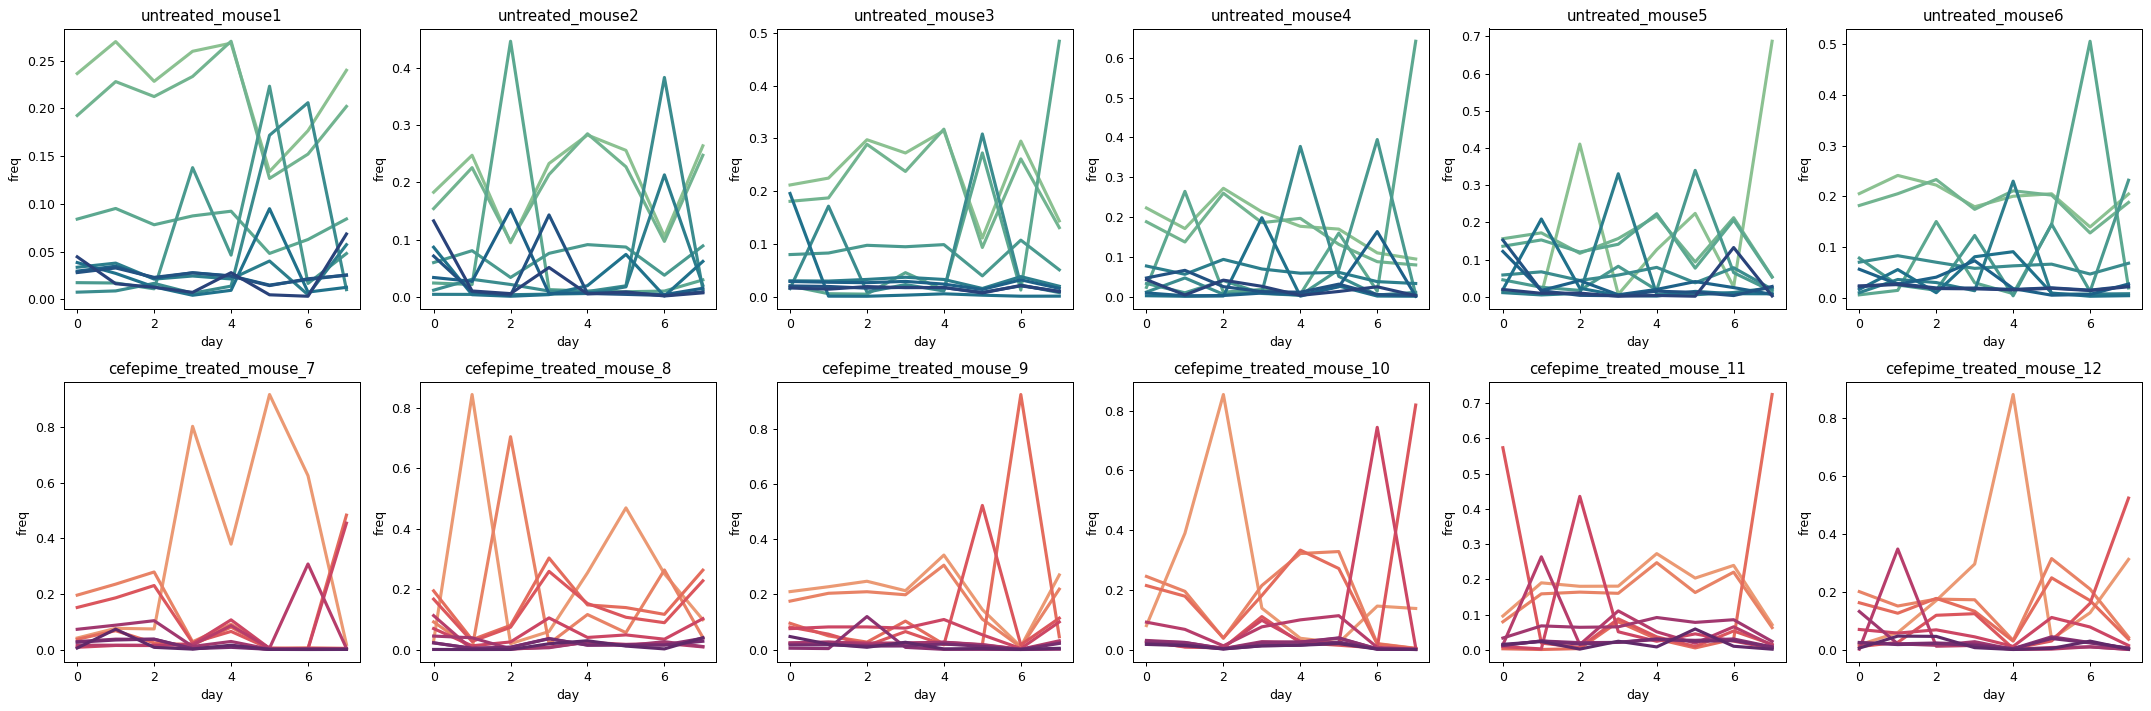

In [10]:
fig, axes = plt.subplots(2, 6, figsize=(24,8), dpi=90)
samples = pd.Series(trajectories.keys())
for unt, ax_index in zip(samples[samples.str.startswith('untreated')].values, list(range(6))):
    ax = axes[0,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=10), x='day', y='freq', hue='barcode', palette="crest", linewidth=2.5, legend=False)
    ax.set_title(unt)
for unt, ax_index in zip(samples[samples.str.startswith('cefepime')].values, list(range(6))):
    ax = axes[1,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=10), x='day', y='freq', hue='barcode', palette="flare", linewidth=2.5, legend=False)
    ax.set_title(unt)
plt.tight_layout()

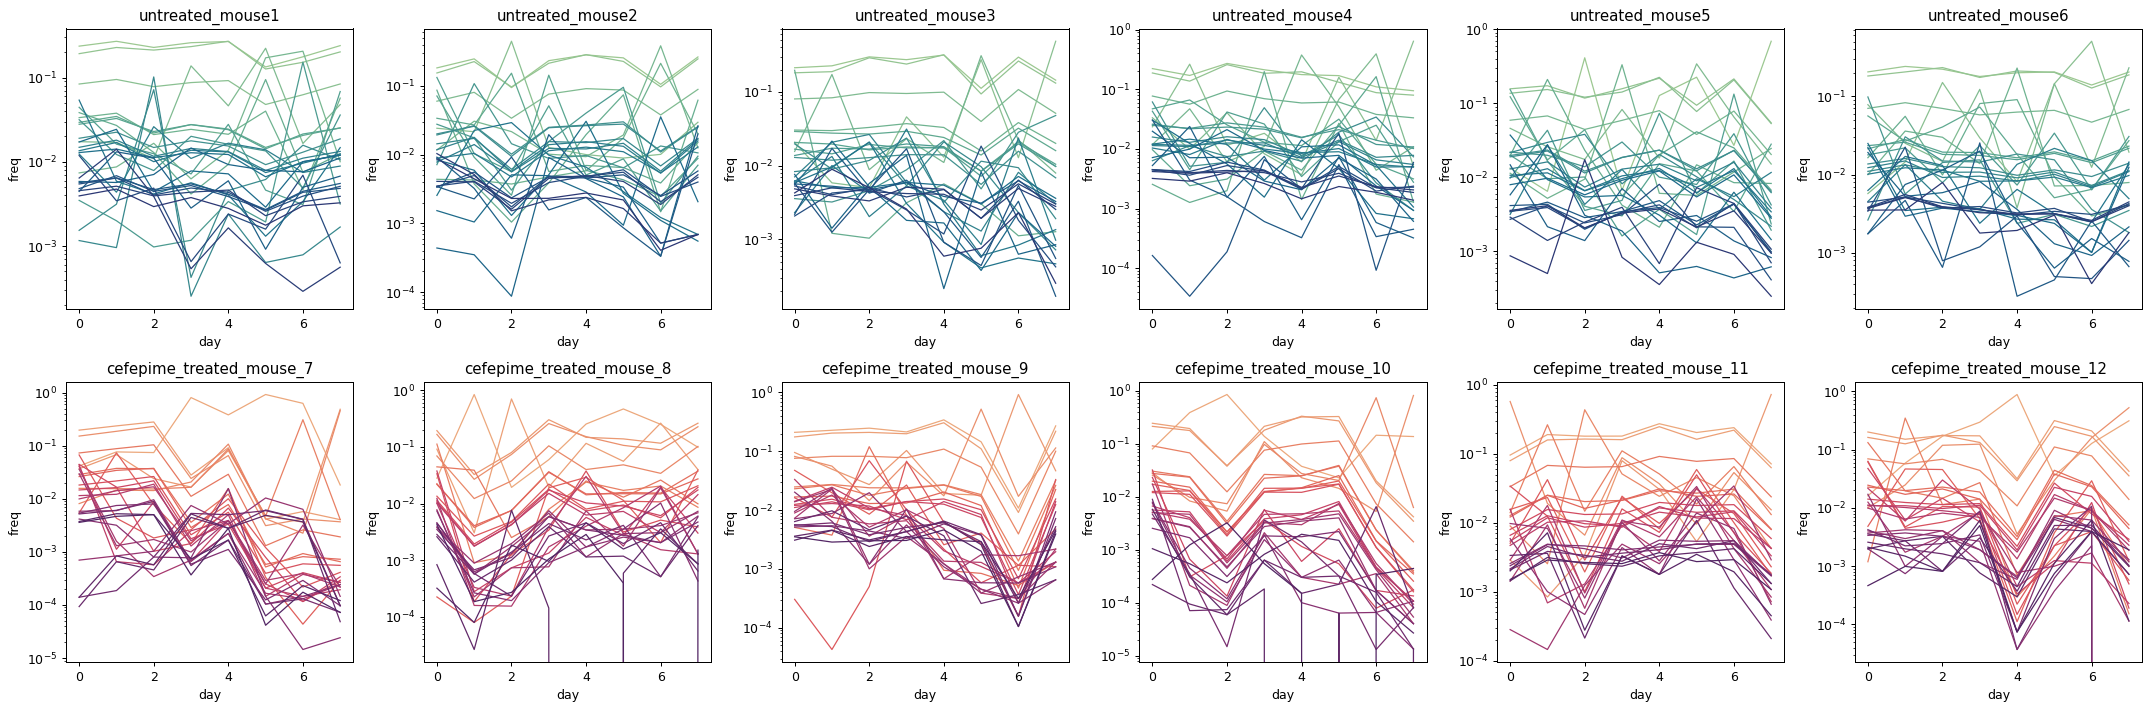

In [11]:
fig, axes = plt.subplots(2, 6, figsize=(24,8), dpi=90)
samples = pd.Series(trajectories.keys())
for unt, ax_index in zip(samples[samples.str.startswith('untreated')].values, list(range(6))):
    ax = axes[0,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=30), x='day', y='freq', hue='barcode', palette="crest", linewidth=1, legend=False)
    ax.set_title(unt)
    ax.set_yscale('log')
for unt, ax_index in zip(samples[samples.str.startswith('cefepime')].values, list(range(6))):
    ax = axes[1,ax_index]
    sns.lineplot(ax=ax, data=get_freq_plot_table(traj_norm, unt, top=30), x='day', y='freq', hue='barcode', palette="flare", linewidth=1, legend=False)
    ax.set_title(unt)
    ax.set_yscale('log')
plt.tight_layout()

#### Evolution of Shannon diversity index and number of unique barcodes

In [18]:
def shannon_index(vect):
    vect = vect[vect>0]
    return -sum([x*np.log(x) for x in vect])

shannon_dfs=[]
for mouse in traj_norm.keys():
    shannon_df = traj_norm[mouse].set_index('barcode').apply(shannon_index, axis=0).to_frame(name=mouse)
    shannon_dfs.append(shannon_df)
shannon_df = pd.concat(shannon_dfs,axis=1)
shannon_df.to_csv('Evolution of Shannon diversity index.csv')
shannon_df

,untreated_mouse1,untreated_mouse2,untreated_mouse3,untreated_mouse4,untreated_mouse5,untreated_mouse6,cefepime_treated_mouse_7,cefepime_treated_mouse_8,cefepime_treated_mouse_9,cefepime_treated_mouse_10,cefepime_treated_mouse_11,cefepime_treated_mouse_12
0,2.918351,2.955528,2.750224,2.925237,2.988444,2.924039,3.105068,2.944551,2.898936,2.793134,1.958849,2.905938
1,2.717949,2.653222,2.748196,2.720783,2.852064,2.869685,2.744605,0.853758,2.936141,2.026879,2.612815,2.471700
2,2.790496,2.113873,2.416940,2.611229,2.458832,2.671300,2.519925,1.415641,2.684592,0.815682,1.965084,2.684520
3,2.522752,2.703520,2.631475,2.701926,2.493332,2.904963,1.143433,2.363564,2.799003,2.523852,2.892940,2.481488
4,2.613489,2.501117,2.219418,2.180612,2.709982,2.449689,2.404830,2.612725,2.134473,2.048350,2.582152,0.677209
5,2.562491,2.572865,2.260956,3.025873,2.409195,2.546125,0.564326,2.124027,1.922775,2.222604,3.084673,2.346038
6,2.676677,2.144834,2.441607,2.296882,2.706009,2.012327,1.073576,2.484213,0.508261,1.110603,2.747221,2.623673
7,2.801231,2.615902,1.972518,1.696925,1.607514,2.624350,1.083508,2.480426,2.487685,0.729997,1.360196,1.478648


In [20]:
uniq_barcodes=[]
for mouse in traj_norm.keys():
    uniq = (traj_norm[mouse].iloc[:,1:]>0).sum().to_frame(name=mouse)
    uniq_barcodes.append(uniq)
uniq_barcodes = pd.concat(uniq_barcodes,axis=1)
uniq_barcodes.to_csv('Evolution of unique barcode count.csv')
uniq_barcodes

,untreated_mouse1,untreated_mouse2,untreated_mouse3,untreated_mouse4,untreated_mouse5,untreated_mouse6,cefepime_treated_mouse_7,cefepime_treated_mouse_8,cefepime_treated_mouse_9,cefepime_treated_mouse_10,cefepime_treated_mouse_11,cefepime_treated_mouse_12
0,587,298,211,299,489,631,400,481,334,353,426,329
1,491,191,347,561,517,416,244,242,422,260,783,115
2,579,240,277,332,357,314,172,209,229,244,268,75
3,1505,345,224,419,722,444,196,220,132,181,197,93
4,311,198,246,264,606,422,79,80,130,180,157,121
5,432,210,271,128,565,413,156,105,177,262,593,140
6,485,252,208,313,341,510,195,91,102,252,154,85
7,383,169,227,281,216,317,167,114,130,176,218,165


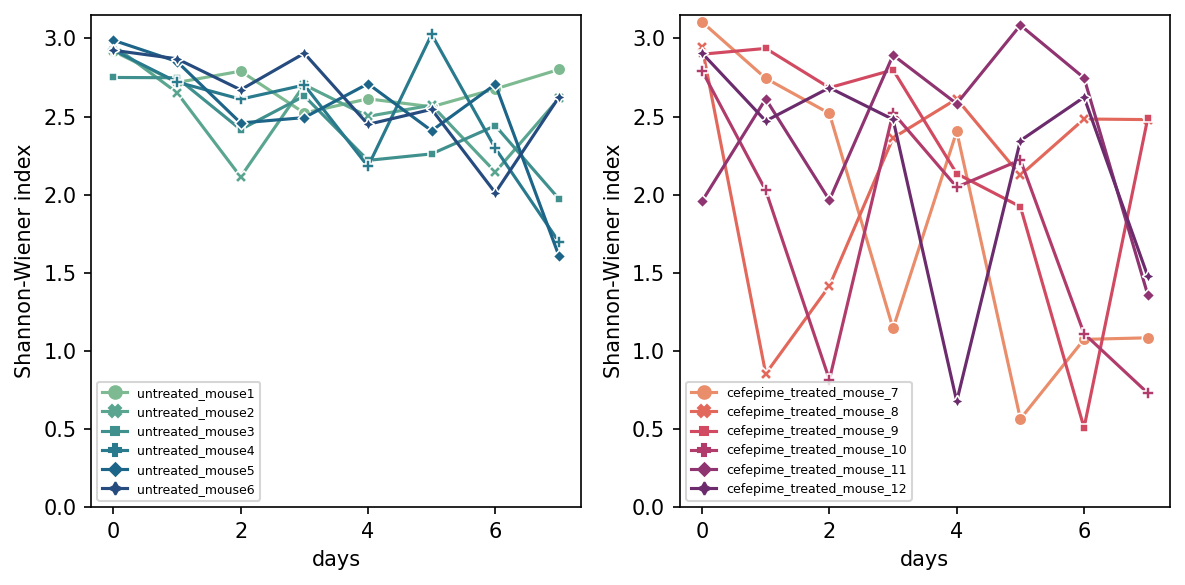

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,4), dpi=150)

ax=axes[0]
sns.lineplot(data=shannon_df.iloc[:,:6], palette='crest', dashes=False, markers=True, ax=ax)
ax.set_ylim([0,3.15])
ax.set_ylabel('Shannon-Wiener index')
ax.set_xlabel('days')
ax.legend(loc='lower left', fontsize=6)
ax=axes[1]
sns.lineplot(data=shannon_df.iloc[:,6:], palette='flare', dashes=False, markers=True, ax=ax)
ax.set_ylim([0,3.15])
ax.set_ylabel('Shannon-Wiener index')
ax.set_xlabel('days')
ax.legend(loc='lower left', fontsize=6);
plt.tight_layout()
plt.savefig('shannon diversity individual samples.jpg', dpi=300)

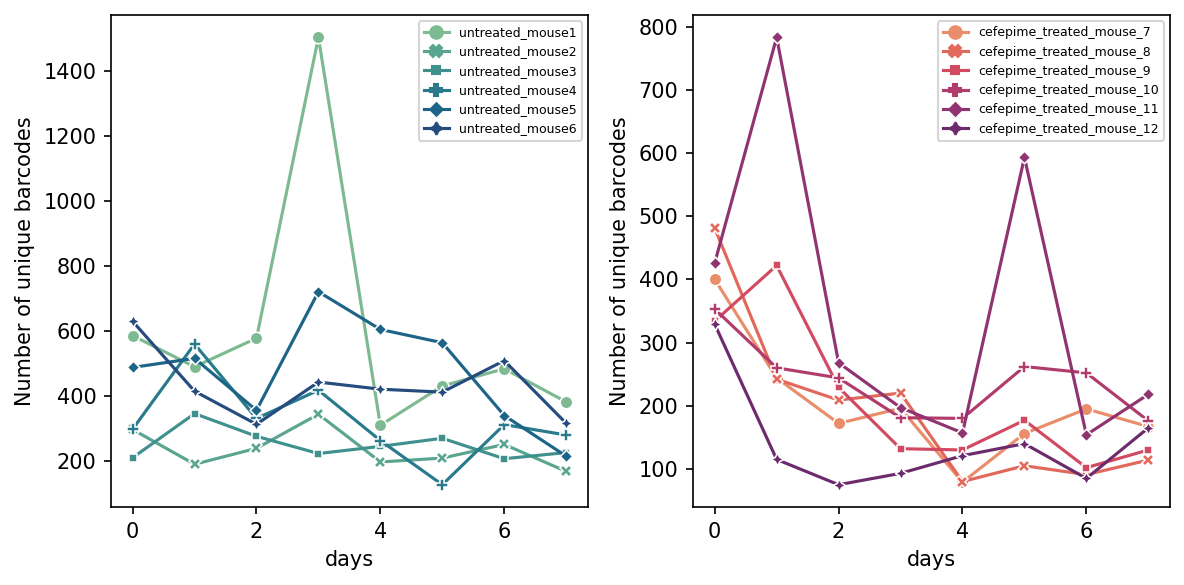

In [15]:
fig, axes = plt.subplots(1,2, figsize=(8,4), dpi=150)

ax=axes[0]
sns.lineplot(data=uniq_barcodes.iloc[:,:6], palette='crest', dashes=False, markers=True, ax=ax)
#ax.set_ylim([0,3.15])
ax.set_ylabel('Number of unique barcodes')
ax.set_xlabel('days')
ax.legend(loc='upper right', fontsize=6)
ax=axes[1]
sns.lineplot(data=uniq_barcodes.iloc[:,6:13], palette='flare', dashes=False, markers=True, ax=ax)
#ax.set_ylim([0,3.15])
ax.set_ylabel('Number of unique barcodes')
ax.set_xlabel('days')
ax.legend(loc='upper right', fontsize=6);
plt.tight_layout()
plt.savefig('number of unique barcodes individual samples.jpg', dpi=300)

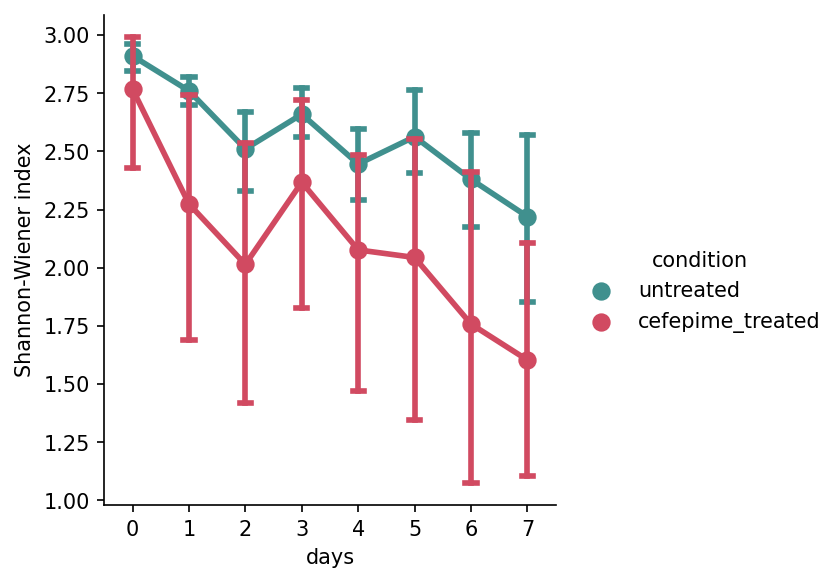

In [21]:
shannon_df['days'] = shannon_df.index
shannon_melt = shannon_df.melt(id_vars='days')

shannon_melt.loc[shannon_melt['variable'].str.startswith('untreated'), 'condition'] = 'untreated'
shannon_melt.loc[shannon_melt['variable'].str.startswith('cefepime'), 'condition'] = 'cefepime_treated'

colors = [sns.color_palette('crest')[2], sns.color_palette('flare')[2]]
g = sns.catplot(
    data=shannon_melt, x="days", y="value", hue="condition",
    capsize=0.2, palette=colors, errorbar="se",
    kind="point", height=4
)
g.fig.set_figwidth(6)
g.fig.set_dpi(150)
g.ax.set_ylabel('Shannon-Wiener index');
shannon_melt.to_csv('Shannon diversity index mean+se.csv')
g.fig.savefig('shannon diversity mean+se.jpg', dpi=300)

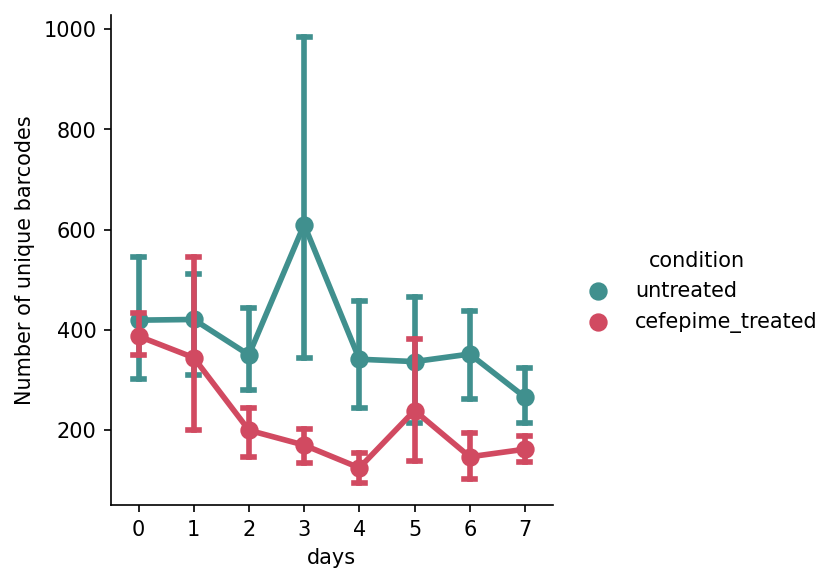

In [22]:
uniq_barcodes['days'] = uniq_barcodes.index
uniq_barcodes_melt = uniq_barcodes.melt(id_vars='days')

uniq_barcodes_melt.loc[uniq_barcodes_melt['variable'].str.startswith('untreated'), 'condition'] = 'untreated'
uniq_barcodes_melt.loc[uniq_barcodes_melt['variable'].str.startswith('cefepime'), 'condition'] = 'cefepime_treated'

colors = [sns.color_palette('crest')[2], sns.color_palette('flare')[2]]
g = sns.catplot(
    data=uniq_barcodes_melt, x="days", y="value", hue="condition",
    capsize=0.2, palette=colors, errorbar="se",
    kind="point", height=4
)
g.fig.set_figwidth(6)
g.fig.set_dpi(150)
g.ax.set_ylabel('Number of unique barcodes');
uniq_barcodes_melt.to_csv('number of unique barcodes mean+se.csv')
g.fig.savefig('number of unique barcodes mean+se.jpg', dpi=300)

In [47]:
(traj_norm[mouse].iloc[:,1:]>0).sum().to_frame(name=mouse)

0     587
1     491
2     579
3    1505
4     311
5     432
6     485
7     383
dtype: int64

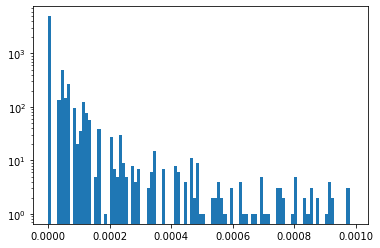

In [43]:
plt.hist(traj_norm['untreated_mouse3'].iloc[:,1:].values.flatten(),bins=np.arange(0,0.001,0.00001))
plt.yscale('log')

In [48]:
# Load the example exercise dataset
exercise = sns.load_dataset("exercise")
exercise

,Unnamed: 0,id,diet,pulse,time,kind
0,0,1,low fat,85,1 min,rest
1,1,1,low fat,85,15 min,rest
2,2,1,low fat,88,30 min,rest
3,3,2,low fat,90,1 min,rest
4,4,2,low fat,92,15 min,rest
...,...,...,...,...,...,...
85,85,29,no fat,135,15 min,running
86,86,29,no fat,130,30 min,running
87,87,30,no fat,99,1 min,running
88,88,30,no fat,111,15 min,running


#### Evolution of the number of unique barcodes

#### Plot total barcoded read count over time

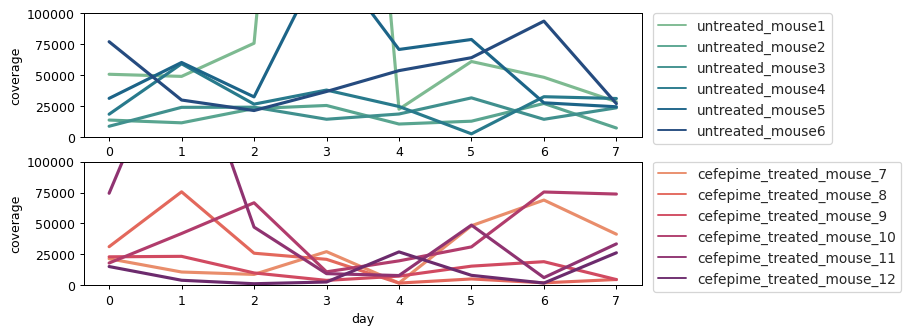

In [14]:
fig, axes = plt.subplots(2,1,figsize=(8,4), dpi=90)
sns.set_theme(style="white")
sns.lineplot(data=traj_cov[traj_cov['sample'].str.startswith('untreated')], x='day', y='coverage', hue='sample', palette="crest", linewidth=2.5, ax=axes[0])
sns.lineplot(data=traj_cov[traj_cov['sample'].str.startswith('cefepime')], x='day', y='coverage', hue='sample', palette="flare", linewidth=2.5, ax=axes[1])
for ax in axes:
    ax.set_yscale('linear')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_ylim([0, 100000])

#### Barcode frequency correlation between mice

In [19]:
plotdf=[]
top=1000
for sample_name in samples:#[samples.str.startswith('untreated')]:
    selected_sample = traj_norm[sample_name]
    ssum = selected_sample.sum(axis=1).sort_values(ascending=False)
    for ix, row in selected_sample.loc[ssum.index,:].iloc[:,:].iterrows():
        for day in selected_sample.columns[1:]:
            plotdf.append({'barcode': row['barcode'], 'sample': sample_name, 'day': int(day), 'freq':row[day]})
plotdf=pd.DataFrame(plotdf)
plotdf

,barcode,sample,day,freq
0,AAGGTGACAGT,untreated_mouse1,0,0.236558
1,AAGGTGACAGT,untreated_mouse1,1,0.270031
2,AAGGTGACAGT,untreated_mouse1,2,0.228342
3,AAGGTGACAGT,untreated_mouse1,3,0.259865
4,AAGGTGACAGT,untreated_mouse1,4,0.268385
...,...,...,...,...
106027,AACGGATCCTC,cefepime_treated_mouse_12,3,0.000000
106028,AACGGATCCTC,cefepime_treated_mouse_12,4,0.000037
106029,AACGGATCCTC,cefepime_treated_mouse_12,5,0.000000
106030,AACGGATCCTC,cefepime_treated_mouse_12,6,0.000000


In [20]:
plotdf[plotdf['freq']>0.001].groupby(['barcode','day'])[['freq']].agg(len)

freq
barcode     day      
AAAGAACCGGT 0      12
            1       9
            2       8
            3      12
            4       8
...               ...
ATGGTTACTTA 1       2
            2       1
            5       1
            6       1
___TGTTCAGC 4       1

[522 rows x 1 columns]

(0.5, 12.5)

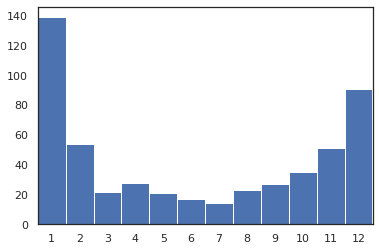

In [22]:
abundant_barcodes = plotdf[plotdf['freq']>0.001]

plt.hist(abundant_barcodes.groupby(['barcode','day'])[['freq']].agg(len).values.flatten(), align='left', bins=np.arange(0,14));

#plt.title(f"Total of {abundant_barcodes.groupby('barcode')['barcode'].shape[0]} barcodes with $freq>0.001$")
plt.xticks(np.arange(0,13));
plt.xlim(0.5,12.5)

In [28]:
sorted_index = plotdf.groupby(['barcode'])['freq'].agg(sum).sort_values(ascending=False).index
df = plotdf.set_index('barcode').loc[sorted_index[:30],:].reset_index()
df['treated']=df['sample'].apply(lambda s: s.split('_')[0])
df

,barcode,sample,day,freq,treated
0,AAGGTGACAGT,untreated_mouse1,0,0.236558,untreated
1,AAGGTGACAGT,untreated_mouse1,1,0.270031,untreated
2,AAGGTGACAGT,untreated_mouse1,2,0.228342,untreated
3,AAGGTGACAGT,untreated_mouse1,3,0.259865,untreated
4,AAGGTGACAGT,untreated_mouse1,4,0.268385,untreated
...,...,...,...,...,...
2875,ATGGCTTCAAA,cefepime_treated_mouse_12,3,0.004966,cefepime
2876,ATGGCTTCAAA,cefepime_treated_mouse_12,4,0.000074,cefepime
2877,ATGGCTTCAAA,cefepime_treated_mouse_12,5,0.000747,cefepime
2878,ATGGCTTCAAA,cefepime_treated_mouse_12,6,0.003928,cefepime


In [29]:
df.to_csv('top30_common_barcodes.csv', index=False)

In [25]:
df[df['freq']>0.001].groupby(['barcode','sample'])['freq'].agg(list)

barcode      sample                   
AAAGAACCGGT  cefepime_treated_mouse_10        [0.0016116483272201846, 0.001930856932695844]
             cefepime_treated_mouse_11    [0.005883064028690011, 0.00100189611180037, 0....
             cefepime_treated_mouse_12    [0.004225538095866895, 0.002226620484908461, 0...
             cefepime_treated_mouse_7     [0.04341345258058506, 0.0025002757657094535, 0...
             cefepime_treated_mouse_8     [0.004518072289156626, 0.0026685727900881582, ...
                                                                ...                        
ATGGTAGCACA  untreated_mouse4                                       [0.0016821314233002333]
ATGGTTACTTA  cefepime_treated_mouse_10         [0.00121741621311945, 0.0015127460084474133]
             cefepime_treated_mouse_8        [0.0015867978419549348, 0.0015710919088766694]
             cefepime_treated_mouse_9                               [0.0024117862947622293]
___TGTTCAGC  cefepime_treated_mouse_7    

In [ ]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, row="barcode", col="sample", hue="treated", palette="muted", height=1.5)
# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")
# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "day", "freq", marker="o")
# Adjust the tick positions and labels
grid.set(xticks=np.arange(0,8), xticklabels=np.arange(0,8), xlim=(-.5, 8.5), yscale='log', yticks=10.**(np.arange(-3,0)))
for (row_val, col_val), ax in grid.axes_dict.items():
    ax.set_title(f"{col_val.split('_')[0]}")
    ax.set_ylabel(row_val, fontsize=9)
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=0.5)
grid.fig.savefig('top30_common_barcodes.jpg', dpi=150)

In [27]:
df.to

,barcode,sample,day,freq,treated
0,AAGGTGACAGT,untreated_mouse1,0,0.236558,untreated
1,AAGGTGACAGT,untreated_mouse1,1,0.270031,untreated
2,AAGGTGACAGT,untreated_mouse1,2,0.228342,untreated
3,AAGGTGACAGT,untreated_mouse1,3,0.259865,untreated
4,AAGGTGACAGT,untreated_mouse1,4,0.268385,untreated
...,...,...,...,...,...
106027,AAAAGCGCTTC,untreated_mouse1,3,0.000001,untreated
106028,AAAAGCGCTTC,untreated_mouse1,4,0.000000,untreated
106029,AAAAGCGCTTC,untreated_mouse1,5,0.000000,untreated
106030,AAAAGCGCTTC,untreated_mouse1,6,0.000000,untreated


In [ ]:
selected_sample = traj_norm['untreated_mouse1']
#ssum = selected_sample.sum().sort_values(ascending=False)
selected_sample.sum(axis=1).sort_values(ascending=False).index

/tmp/ipykernel_141231/2166244442.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  selected_sample.sum(axis=1).sort_values(ascending=False).index


Int64Index([   0,    1,    2,   11,   18,    6,    5,    8,    9,    4,
            ...
            1697, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1487],
           dtype='int64', length=2172)